# Drop Size Distribution retrieval


In the following, we introduce the use of the pyOptimalEstimation Python library using a radar-based drop-size distribution (DSD) retrieval as an example. 
\citep{williams_describing_2014} suggested to parameterize a DSD using a scaling parameter $N_w$ as well as the raindrop mass spectrum mean diameter $D_m$ and its standard deviation $\sigma_m$.
Assuming that the DSD follows a gamma distribution, $\sigma_m$ is related to the shape parameter $\mu$ with 
\begin{equation} 
    \mu = (D_m/\sigma)^2 -4
\end{equation}
and we reconstruct the original DSD $N(D)$ as a function of maximum dimension $D$ with
\begin{equation}
    N(D) = N_w \frac{6}{256} \frac{(4+\mu)^{\mu+4}}{\Gamma(\mu+4)} \Big(\frac{D}{D_m}\Big)^{\mu} \exp \Big[ -(4+\mu) \frac{D}{D_m}\Big]
\end{equation}
using the normalization approach by \citet{testud_concept_2001}.

\citet{williams_describing_2014} analyzed the correlations between $D_m$ and $\sigma_m$ in  detail and proposed to use a modified quantity $\sigma_m\!'$ defined with 
\begin{equation}
    \sigma_m\!' = \sigma_m D_m^{-1.36}
\end{equation}
in order to minimize the correlation to $D_m$. The three parameters required to estimate the DSD ($N_w$, $D_m$, and $\sigma_m$ or $\sigma_m\!'$) will form our state vector $\mathbf{x}$. 


A radar simulator will use $\mathbf{x}$ to estimate the measurement vector $\mathbf{y}$ consisting of the radar reflectivity factor ($Z_e$ in dBz) and the mean Doppler velocity ($V_d$ in m s$^{-1}$) with 
    \begin{equation}
    Z_e = 10 \times \log_{10} (10^{18} \times \sum_i N(D_i) \times \frac{\lambda^4}{|K_w|^2 \pi^5} \times \sigma(D_i) \times \Delta D ) 
    \end{equation}  
and
        \begin{equation}
V_d = \frac{\sum_i v(D_i) \times N(D_i) \times  \sigma(D_i) \times \Delta D}{\sum_i N(D_i) \times  \sigma(D_i) \times \Delta D}
    \end{equation}
where $i$ the index of the discrete DSD and $\sigma$ and $v$ are the functions to describe backscattering cross section and fall velocity, respectively. This means we have two measurements to derive three quantities of the state space, i.e. the problem is not unambiguous. 
In order to obtain the required prior data set, we use the Huntsville data set introduced in \citep{williams_describing_2014} which consists of 18969 individual DSD distributions obtained at Huntsville, AL from December 2009 to October 2011. For every DSD, \citet{williams_describing_2014} determined $N_w$, $D_m$, and $\sigma_m$ and we determine the a-priori assumption $\mathbf{x}_a$ and uncertainty ($\mathbb{S}_a$) form the mean and the covariance of the data set, respectively. 

This example has been developed using Python 3.6, Numpy 1.16.2, Matpolotlib 3.0.3, Scipy 1.2.1, Xarray 0.11.3, Pandas 0.24.1, Seaborn 0.9.0 and Uncertainties 3.0.3


# Installation 
In order to design a retrieval with pyOptimalEstimation, we need to install the library first with 
~~~~  
pip install pyOptimalEstimation
~~~~ 
for Python 2.7 or Python 3. This example uses Python 3.6. It requires the numpy, scipy, pandas and matplotlib libraries to be installed, this example makes use also of the xarray, seaborn, uncertainties, and xarray libraries. For development, we used Numpy 1.16.2, Matpolotlib 3.0.3, Scipy 1.2.1, Xarray 0.11.3, Pandas 0.24.1, Seaborn 0.9.0 and Uncertainties 3.0.3. 

The radar simulations are done with the Passive and Active Microwave radiative TRAnsfer model (PAMTRA) \citep{maahn_how_2015}. Here, we use version 2 that is in active development, so we install a specific version with:
~~~~ 
pip install git+git://github.com/maahn/pamtra2.git@461b711ae366b791665687de5dec37abd7ab78f5
~~~~ 



# Preparation

We start with loading the required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pn
import xarray as xr
import uncertainties.unumpy as unp
import seaborn as sns

import pamtra2

import pyOptimalEstimation as pyOE

%matplotlib inline
sns.set(style='ticks', palette='deep')
abc = 'abcdefghijk'

ModuleNotFoundError: No module named 'numpy'

We put some helper routines in a separate file which we load with 

In [2]:
import sys
sys.path.append('lib')
import supporting_routines
from importlib import reload
reload(supporting_routines)

<module 'supporting_routines' from 'lib/supporting_routines.py'>

## State vector


In order to load the required prior data set, we load the Huntsville data set of \citep{williams_describing_2014} from a netCDF file using xarray:

In [3]:
rainDat = xr.open_dataset('data/huntsville_parameters.nc')

and add logarithmic variables with

In [4]:
rainDat['Nw_log10'] = np.log10(rainDat['Nw'])
rainDat['Dm_log10'] = np.log10(rainDat['Dm'])
rainDat['Sm_log10'] = np.log10(rainDat['Sm'])
rainDat['Smprime_log10'] = np.log10(rainDat['Smprime'])

rainDat

<xarray.Dataset>
Dimensions:        (time: 18969)
Coordinates:
  * time           (time) datetime64[ns] 2009-12-13T04:24:00 ... 2011-04-04T21:51:00
Data variables:
    Dm             (time) float64 1.117 1.003 1.014 1.112 ... 1.377 1.475 1.476
    Z              (time) float64 ...
    Nw             (time) float64 2.328e+03 4.55e+03 ... 3.125e+03 1.156e+03
    Sm             (time) float64 0.3556 0.2533 0.2561 ... 0.5925 0.5747 0.5636
    Smprime        (time) float64 0.3058 0.2524 0.2513 ... 0.3837 0.3386 0.3318
    Nw_log10       (time) float64 3.367 3.658 4.037 3.925 ... 3.581 3.495 3.063
    Dm_log10       (time) float64 0.04817 0.001143 0.00605 ... 0.1689 0.1692
    Sm_log10       (time) float64 -0.449 -0.5964 -0.5916 ... -0.2406 -0.249
    Smprime_log10  (time) float64 -0.5145 -0.598 -0.5999 ... -0.4703 -0.4791

We use 100 randomly chosen DSDs for the test data set and use the remaining DSDs for the training data set, i.e. to develop the retrieval.

In [5]:
nTest = 100

np.random.seed(10)
ii = np.arange(len(rainDat.time))
np.random.shuffle(ii)
testII, trainingII = ii[:nTest], ii[nTest:]

rainDat_test = rainDat.isel(time=testII)
rainDat_training = rainDat.isel(time=trainingII)

In order to asses the assumptions that the state variables follow a Gaussian distribution, we make QQ plots. Comparison of the first and second column reveals that a logarithmic state vector $\mathbf{x}$ is much closer to a Gaussian distribution than the linear version. Using a normalized  $\sigma_m\!'$ instead of $\sigma_m$ (third column) changes the the QQ plot only slightly. 

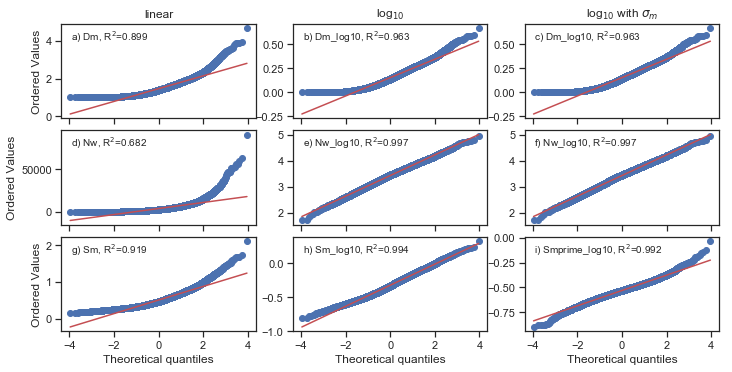

In [6]:
fig, sps = plt.subplots(figsize=(10, 5), nrows=3, ncols=3, sharex=True)
sps = sps.reshape((3, 3))

jj = 0

for kk in range(3):
    for ii, (x_name, x_vars) in enumerate([
        ('linear', ['Dm', 'Nw', 'Sm']),
        ('log$_{10}$', ['Dm_log10', 'Nw_log10', 'Sm_log10']),
        ('log$_{10}$ with $\sigma_m\!$',
         ['Dm_log10', 'Nw_log10', 'Smprime_log10']),
    ]):

        x_var = x_vars[kk]

        (osm, osr), (slope, intercept, r) = stats.probplot(
            rainDat_training[x_var],
            dist="norm",
            plot=sps[kk, ii],
            fit=True,
            rvalue=False)

        if kk > 0:
            sps[kk, ii].set_title('')
        else:
            sps[kk, ii].set_title(x_name)

        sps[kk, ii].text(
            0.05,
            0.95,
            '%s) %s, R$^2$=%.3g' % (abc[jj], x_var, r**2),
            horizontalalignment='left',
            verticalalignment='top',
            transform=sps[kk, ii].transAxes)
        if kk < 2:
            sps[kk, ii].set_xlabel("")
        if ii > 0:
            sps[kk, ii].set_ylabel("")
        jj += 1

fig.tight_layout(pad=0.1, h_pad=0, w_pad=0.)
fig.savefig('qq_x_lin_log.pdf')

The prior $\mathbf{x}_{a}$ and covariance $\mathbb{S}_a$ of the state vector are estimated from the training data set. For convenience, we estimate it for the linear and logarithmic variables together and select the required quantities later. 

In [7]:
S_a = rainDat_training.to_dataframe().cov()
x_ap = rainDat_training.to_dataframe().mean()
print(x_ap)
print(S_a)

Dm                  1.461640
Z                  30.182973
Nw               4054.575495
Sm                  0.508677
Smprime             0.299574
Nw_log10            3.436274
Dm_log10            0.153298
Sm_log10           -0.321980
Smprime_log10      -0.530466
dtype: float64
                       Dm            Z            Nw          Sm    Smprime  \
Dm               0.128514     1.932112 -4.313570e+02    0.060745  -0.000075   
Z                1.932112    43.197216  4.450109e+03    0.928495   0.004110   
Nw            -431.356978  4450.109250  1.825811e+07 -245.675187 -32.369253   
Sm               0.060745     0.928495 -2.456752e+02    0.037466   0.004799   
Smprime         -0.000075     0.004110 -3.236925e+01    0.004799   0.002993   
Nw_log10        -0.055004     0.466462  1.364035e+03   -0.029446  -0.002567   
Dm_log10         0.034559     0.535298 -1.247184e+02    0.016427   0.000055   
Sm_log10         0.047102     0.738148 -2.191039e+02    0.029210   0.004266   
Smprime_log10

When estimating the prior, the use of SI units is not always recommended: Combining small and large quantities with different units (e.g. temperature in K and specific humidity in kg/kg), the prior can be singular prohibiting an efficient use. $\mathbb{S}_a$ is visualized

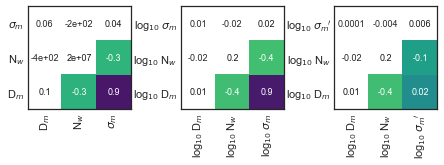

In [8]:
fig, [sp1, sp2, sp3] = plt.subplots(ncols=3)
supporting_routines.plotCorrelation(
    S_a[['Dm', 'Nw', 'Sm']].loc[['Dm', 'Nw', 'Sm']],
    fig,
    sp1,
    tickLabels=supporting_routines.niceKeys)
supporting_routines.plotCorrelation(
    S_a[['Dm_log10', 'Nw_log10',
         'Sm_log10']].loc[['Dm_log10', 'Nw_log10', 'Sm_log10']],
    fig,
    sp2,
    tickLabels=supporting_routines.niceKeys)

supporting_routines.plotCorrelation(
    S_a[['Dm_log10', 'Nw_log10',
         'Smprime_log10']].loc[['Dm_log10', 'Nw_log10', 'Smprime_log10']],
    fig,
    sp3,
    tickLabels=supporting_routines.niceKeys)

#
fig.tight_layout(pad=0.1, h_pad=0, w_pad=0.2)
fig.savefig('x_corr.pdf')

## Measurement space
The measurement vector $\mathbf{y}$ consists of the radar reflectivity factor ($Z$) and the mean Doppler velocity ($V_d$) at 13.6 GHz and 35.5 GHz. Even though we use only 35.5 GHz in the following, we encourage the reader to experiment with different $\mathbf{y}$ combinations. For  $\mathbb{S}_y$, we assume that the uncertainties of  $Z$ and $V_d$ are 1 dB and 0.3 m s$^{-1}$, respectively, and that the errors are not correlated. Even though these error estimates are generally realistic, the values should be carefully evaluated for a real world application.

In [9]:
y_vars = ["Ze_13.6", "MDV_13.6", "Ze_35.5", "MDV_35.5"]
y_noise = np.array([1, .3, 1, .3])
S_y = pn.DataFrame(
    np.diag(y_noise**2),
    index=y_vars,
    columns=y_vars,
)
S_y

,Ze_13.6,MDV_13.6,Ze_35.5,MDV_35.5
Ze_13.6,1.0,0.00,0.0,0.00
MDV_13.6,0.0,0.09,0.0,0.00
Ze_35.5,0.0,0.00,1.0,0.00
MDV_35.5,0.0,0.00,0.0,0.09


## Retrieval
To prepare the retrieval, we set up PAMTRA2 properly and create dictionaries to store the results.

In [10]:
pam2Prepared = supporting_routines.preparePamtra(frequencies=[13.6e9, 35.5e9])
resultsOE = {}
failed = {}

Did not find information about relativePermittivityIce. This might cause trouble later.


/Users/mmaahn/miniconda3/envs/py36/lib/python3.6/site-packages/pamtra2-0.1-py3.6-macosx-10.7-x86_64.egg/pamtra2/libs/singleScattering/scattering_utilities.py:170: RuntimeWarning: invalid value encountered in double_scalars
  alpha = np.arccos((cos_sca-cos_th*cos_inc)/(sin_th*sin_inc))
/Users/mmaahn/miniconda3/envs/py36/lib/python3.6/site-packages/pamtra2-0.1-py3.6-macosx-10.7-x86_64.egg/pamtra2/libs/singleScattering/scattering_utilities.py:171: RuntimeWarning: invalid value encountered in double_scalars
  beta = np.arccos((cos_inc-cos_th*cos_sca)/(sin_th*sin_sca))


We run the retrieval for three configurations:

1. linear state variables
2. logarithmic state variables
3. logarithmic orthogonal state variables with $\sigma_m\!'$ instead of $\sigma_m$

In [11]:

x_names = dict([
        ('Linear', ['Dm', 'Nw', 'Sm']),
        ('log$_{10}$', ['Dm_log10', 'Nw_log10', 'Sm_log10']),
        ('log$_{10}$ with $\sigma_m\!$',
         ['Dm_log10', 'Nw_log10', 'Smprime_log10']),
    ])



In this study, we use only a measurement configuration consisting of a radar reflectivity ($Z_e$ in dBz) and the mean Doppler velocity ($V_d$ in m s$^{-1}$). But the example is designed to work also with dual-frequency set ups and we encourage the reader to play around with these. 

The number in the last column is for a factor which is applied to the estimated measurement noise that allows to study the impact of measurement uncertainty on retrieval performance.

In [12]:
y_names = dict([
    #     name, [Y_variables],
    #     ('Z', ["Ze_13.6"]),
    ('ZW', ["Ze_13.6", "MDV_13.6"]),
    #     ('Zdual', ["Ze_13.6", "Ze_35.5"]),
    #     ('ZWdual', ["Ze_13.6", "MDV_13.6", "Ze_35.5", "MDV_35.5"]),
])


# Example retrieval

to do: go step by step through retrieval design

In [13]:
# for k, v in oe.summarize().items():
#     print(k,':')
#     print(v)
#     print()

# Run retrieval
The retrieval is run for all test profiles and all sets of state and measurement variables. 


For simplicity, we use a synthetic observations, i.e. we use PAMTRA2 to simulate an observation based on a known atmospheric state $\mathbf{x}_{truth}$. Even though $\mathbf{x}_{truth}$ is typically unknown in a real-world example, the use of synthetic observations is extremely helpful for assessing retrieval performance. 

The forward operator `forwardPamtra` is simply a Python function accepting $\mathbf{x}$ as an input. Additionally required function arguments are provided through the `forwardKwArgs` dictionary.

The `pyOptimalEstimation` library is object oriented, i.e., we need to create the `oe` object first before running the retrieval with `oe.doRetrieval`. 

If the retrieval converged, we use different measures to evaluate the retrieval quality:
1. Linearity test tests whether the problem is moderately linear following chapter 5.1 of Rodgers (2000). Values lower than 1 indicate that the effect of linearization is smaller than the measurement error and problem is nearly linear. In case $\mathbf{x}_{truth}$  is not available, error patterns of $\mathbb{S}$ can be used instead. 
2. The degrees of freedom for signal (dgf) for each individual variable. 
3. RMS: The root mean square error between the true profile $\mathbf{x}_{truth}$ and the retrieval result $\mathbf{x}_{optimal}$. We normalize with $\mathbf{x}_{a}$ to account for the different units. 
4. $\chi^2$ tests: We use four $\chi^2$ tests as described in chapter 12 of Rodgers (2000). We test whether
    1. the retrieved state $\mathbf{x}_{op}$ agrees with the prior $\mathbb{S}_a$
    2. the observation $\mathbf{y}_{truth}$ corresponding to $\mathbf{x}_{truth}$ agrees with the prior $\mathbb{S}_a$
    3. $\mathbf{y}_{truth}$  agrees with the measurement $\mathbf{y}_{obs}$ given the uncertainties $\mathbb{S}_y$ 
    4. the measurement $\mathbf{y}_{obs}$ agrees with the prior $\mathbb{S}_a$

In [14]:
for x_name, y_name, y_uncertainty_factor in (
    ('Linear', 'ZW', 1),
    ('log$_{10}$', 'ZW', 1),
    ('log$_{10}$ with $\sigma_m\!$', 'ZW', 1),
    ('log$_{10}$ with $\sigma_m\!$', 'ZW', 2),
):

    x_vars = x_names[x_name]
    y_vars = y_names[y_name]

    resultsOE['%s_%s_%i' % (x_name, y_name, y_uncertainty_factor)] = []
    failed['%s_%s_%i' % (x_name, y_name, y_uncertainty_factor)] = []

    #Additional required variables for the forward operator
    forwardKwArgs = {'pam2': pam2Prepared, 'y_vars': y_vars}

    print('#' * 80)
    print(x_name, y_name, y_uncertainty_factor)
    print('#' * 80)

    for tt in range(nTest):
        x_truth = rainDat_test[x_vars].to_dataframe().iloc[tt]
        # simulate observation based on true state x_truth
        y_obs = supporting_routines.forwardPamtra(
            x_truth,
            pam2=pam2Prepared,
            y_vars=y_vars,
        )

        # create optimal estimation object
        oe = pyOE.optimalEstimation(
            x_vars,  # state variable names
            x_ap[x_vars],  # a priori
            S_a[x_vars].loc[x_vars],  # a priori uncertainty
            y_vars,  # measurement variable names
            y_obs,  # observations
            S_y[y_vars].loc[y_vars] * y_uncertainty_factor**
            2,  # observation uncertainty
            supporting_routines.forwardPamtra,  # forward Operator
            forwardKwArgs=forwardKwArgs,  # additonal function arguments
        )

        # Store true profile in `oe` object. This is just for simplicity, it is not
        # used by the retrieval.
        oe.x_truth = x_truth

        # Do the retrieval with max. 10 iterations.
        converged = oe.doRetrieval(maxIter=10)

        if converged:

            # Test whethe rthe retrieval is moderately lienar around x_truth
            oe.linearityTest()

            # Show hdegrees of freedom per variable
            print(oe.dgf_x)

            # Show RMS normalized with prior
            print('RMS', np.sqrt(
                np.mean(((oe.x_truth - oe.x_op) / oe.x_a)**2)))

            # Apply chi2 tests for retrieval quality
            print(oe.chiSquareTest())

            #Store results in xarray DataArray
            summary = oe.summarize(returnXarray=True)
            resultsOE['%s_%s_%i' % (x_name, y_name,
                                    y_uncertainty_factor)].append(summary)
        else:
            failed['%s_%s_%i' % (x_name, y_name,
                                 y_uncertainty_factor)].append(tt)

    #Store results in xarray Dataset structure for later analysis.
    resultsOE['%s_%s_%i' % (x_name, y_name, y_uncertainty_factor)] = xr.concat(
        resultsOE['%s_%s_%i' % (x_name, y_name, y_uncertainty_factor)],
        dim='time')
    
# resultsOEs = xr.concat(resultsOE.values(), dim='configuration')
# resultsOEs['configuration'] = list(resultsOE.keys())
# resultsOEs[].to_dataframe().reset_index()

################################################################################
Linear ZW 1
################################################################################
0.35 s, iteration 1, degrees of freedom: 1.79 of 3. convergence criteria fullfilled  0.024
0.51 s, iteration 2, degrees of freedom: 1.79 of 3.  Done.  0.000
Dm    0.579834
Nw    0.602191
Sm    0.606119
dtype: float64
RMS 0.19374590036917225
Warning. Singular Matrix with rank 2 instead of 3
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    0.169809
Y_Observation_vs_Prior      0.159493
Y_Optimal_vs_Prior          0.159706
X_Optimal_vs_Prior          0.172206
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float6

0.34 s, iteration 1, degrees of freedom: 1.96 of 3. convergence criteria NOT fullfilled  50.065
0.52 s, iteration 2, degrees of freedom: 1.95 of 3. convergence criteria NOT fullfilled  0.266
0.76 s, iteration 3, degrees of freedom: 1.94 of 3. convergence criteria fullfilled  0.003
0.90 s, iteration 4, degrees of freedom: 1.94 of 3.  Done.  0.000
Dm    0.499055
Nw    0.923148
Sm    0.516993
dtype: float64
RMS 0.08861232046314514
Warning. Singular Matrix with rank 2 instead of 3
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    2.882065
Y_Observation_vs_Prior      1.800186
Y_Optimal_vs_Prior          1.800779
X_Optimal_vs_Prior          2.531670
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critic

/Users/mmaahn/miniconda3/envs/py36/lib/python3.6/site-packages/xarray/core/computation.py:561: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 1
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 1
############################################################
reset due to nan: Sm from nan to 0.508677 in iteration 1
0.27 s, iteration 1, degrees of freedom: 0.96 of 3. convergence criteria NOT fullfilled  14.216
0.43 s, iteration 2, degrees of freedom: 1.81 of 3. convergence criteria NOT fullfilled  195.981
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 3
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 3
############################################################
reset due to nan: Sm from nan to 0.508677 in iteration 3
0.58 s, iteration 3, degrees of freedom: 0.96 of 3. convergence criteria NOT fullfilled  14.2

0.54 s, iteration 3, degrees of freedom: 1.60 of 3. convergence criteria fullfilled  0.062
0.74 s, iteration 4, degrees of freedom: 1.60 of 3.  Done.  0.010
Dm    0.289112
Nw    0.899222
Sm    0.410422
dtype: float64
RMS 0.5581428968295309
Warning. Singular Matrix with rank 2 instead of 3
(chi2test
Y_Optimal_vs_Observation    False
Y_Observation_vs_Prior      False
Y_Optimal_vs_Prior          False
X_Optimal_vs_Prior          False
dtype: bool, chi2test
Y_Optimal_vs_Observation    13.192402
Y_Observation_vs_Prior      32.099609
Y_Optimal_vs_Prior          47.269002
X_Optimal_vs_Prior          13.048415
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
0.26 s, iteration 1, degrees of freedom: 1.75 of 3. convergence criteria NOT fullfilled  0.235
0.49 s, iteration 2, degrees of freedom: 1.75 of 3. convergence crite

0.25 s, iteration 1, degrees of freedom: 1.66 of 3. convergence criteria NOT fullfilled  2.057
0.37 s, iteration 2, degrees of freedom: 1.65 of 3. convergence criteria fullfilled  0.000
0.49 s, iteration 3, degrees of freedom: 1.65 of 3.  Done.  0.000
Dm    0.754792
Nw    0.394245
Sm    0.505731
dtype: float64
RMS 0.13145248458565484
Warning. Singular Matrix with rank 2 instead of 3
(chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool, chi2test
Y_Optimal_vs_Observation    1.745571
Y_Observation_vs_Prior      2.213752
Y_Optimal_vs_Prior          2.593577
X_Optimal_vs_Prior          1.747099
Name: chi2value, dtype: float64, chi2test
Y_Optimal_vs_Observation    5.991465
Y_Observation_vs_Prior      5.991465
Y_Optimal_vs_Prior          5.991465
X_Optimal_vs_Prior          5.991465
Name: chi2critical, dtype: float64)
0.28 s, iteration 1, degrees of freedom: 1.89 of 3. convergence criteria NOT

1.55 s, iteration 8, degrees of freedom: 1.81 of 3. convergence criteria NOT fullfilled  35.045
############################################################
reset due to nan: Dm from nan to 1.461640 in iteration 9
############################################################
reset due to nan: Nw from nan to 4054.575495 in iteration 9
############################################################
reset due to nan: Sm from nan to 0.508677 in iteration 9
1.72 s, iteration 9, degrees of freedom: 0.95 of 3. convergence criteria NOT fullfilled  1.918


KeyboardInterrupt: 

In [ ]:
pamtra2.libs.pyPamtraRadarMoments.pyPamtraRadarMomentsLib

# Analyze results

In the following, we evaluate retrieval quality using various methods. First, we make a panda DataFrame with the quantities we are interested in.

In [ ]:
resultsOEMerged = {}
for key in resultsOE.keys():
    if key.startswith('Linear_'):
        resultsOEMerged[key] = resultsOE[key]
    elif key.startswith('log$_{10}$_'):
        assert resultsOE[key].x_vars[0] == 'Dm_log10'
        assert resultsOE[key].x_vars[2] == 'Sm_log10'
        
        linState = {}
        linState['x_truth'] = 10**resultsOE[key].x_truth
        x_op = 10**unp.uarray(resultsOE[key].x_op.values,
                                     resultsOE[key].x_op_err.values)
        x_a = 10**unp.uarray(resultsOE[key].x_a.values,
                                     resultsOE[key].x_a_err.values)

        linState['x_op_err'] = xr.zeros_like(
            linState['x_truth']) + unp.std_devs(x_op)
        linState['x_op'] = xr.zeros_like(
            linState['x_truth']) + unp.nominal_values(x_op)
        linState['x_a_err'] = xr.zeros_like(
            linState['x_truth']) + unp.std_devs(x_a)
        linState['x_a'] = xr.zeros_like(
            linState['x_truth']) + unp.nominal_values(x_a)
        linState['dgf_x'] = resultsOE[key]['dgf_x']

        linState = xr.Dataset(linState)
#         linState = linState.rename({'variable':'x_vars'})
        linState['x_vars'] = ['Dm', 'Nw', 'Sm']
        resultsOEMerged[key] = xr.merge((resultsOE[key],linState))

    elif key.startswith('log$_{10}$ with $\\sigma_m\\!$_'):
        assert resultsOE[key].x_vars[0] == 'Dm_log10'
        assert resultsOE[key].x_vars[2] == 'Smprime_log10'
        
        linState = {}
        linState['x_truth'] = 10**resultsOE[key].x_truth
        linState['x_truth'][:, 2].values = linState[
            'x_truth'][:, 2].values * linState['x_truth'][:, 0].values**1.36
        x_op = 10**unp.uarray(resultsOE[key].x_op.values,
                                     resultsOE[key].x_op_err.values)
        x_op[:, 2] = x_op[:, 2] * x_op[:, 0]**1.36
        x_a = 10**unp.uarray(resultsOE[key].x_a.values,
                                     resultsOE[key].x_a_err.values)
        x_a[:, 2] = x_a[:, 2] * x_a[:, 0]**1.36
        
        linState['x_op_err'] = xr.zeros_like(
            linState['x_truth']) + unp.std_devs(x_op)
        linState['x_op'] = xr.zeros_like(
            linState['x_truth']) + unp.nominal_values(x_op)
        linState['x_a_err'] = xr.zeros_like(
            linState['x_truth']) + unp.std_devs(x_a)
        linState['x_a'] = xr.zeros_like(
            linState['x_truth']) + unp.nominal_values(x_a)

        linState['dgf_x'] =  resultsOE[key]['dgf_x']


        linState = xr.Dataset(linState)
#         linState = linState.rename({'variable':'x_vars'})

        linState['x_vars'] = ['Dm', 'Nw', 'Sm']
        resultsOEMerged[key] = xr.merge((resultsOE[key],linState))

    else:
        raise ValueError

In [ ]:

df = []

for xx, (x_name, y_name, y_uncertainty_factor) in enumerate((
    ('Linear', 'ZW', 1),
    ('log$_{10}$', 'ZW', 1),
    ('log$_{10}$ with $\\sigma_m\\!$', 'ZW', 1),
    ('log$_{10}$ with $\\sigma_m\\!$', 'ZW', 2),
)):

    x_vars = ['Nw', 'Dm', 'Sm']
    y_vars = y_names[y_name]

    y_name2 = '%s' % (y_name)
    x_name2 = '%s_%i' % (x_name, y_uncertainty_factor)

    for xx, x_var in enumerate(x_vars):
        thisOe = resultsOEMerged['%s_%s_%i' % (x_name, y_name,
                                         y_uncertainty_factor)].sel(
                                             x_vars=x_var)
        for ii in range(len(thisOe.time)):

            dgf = thisOe.dgf_x.values[ii]
            re = (thisOe.x_op_err.values[ii] / thisOe.x_op.values[ii])
            ri = (thisOe.x_op_err.values[ii] / thisOe.x_a_err.values[ii])

            df.append((dgf, re, ri, np.nan, np.nan, x_var, x_var.split('_')[0].replace(
                           'prime', ''), y_name2, x_name2))
    for ii in range(len(thisOe.time)):
        cv = thisOe.chi2value[ii]
        cc = thisOe.chi2critical[ii]
        nn = thisOe.trueNonlinearity.values[ii]

        dgf_tot = thisOe.dgf.values[ii]
        df.append((dgf_tot, np.nan, np.nan, (cv <= cc).all('chi2test').values,
                       nn < 0.1, 'total', 'total', y_name2,
                    x_name2))

df = pn.DataFrame(
    df,
    columns=[
        'degrees of freedom', 'relative error', 'relative improvement',
        'chi2Test', 'nonlinearTest', 'x_var', 'x_var_simple', 'y_name',
        'x_name'
    ])

## Retrieval error distribution

The fact that we know $\mathbf{x}_{truth}$ allows us to investigate the distributions of the retrieval errors. When defined with

   \begin{equation}
   \frac{\mathbf{x}_{op} - \mathbf{x}_{truth}}{\sqrt{(\textrm{diag}( \mathbb{S}_y)}}
   \end{equation}

with  $\mathbb{S}$ is the retrieval uncertainty of $\mathbf{x}_{truth}$, it should follow a normal distribution with mean 0 and standard deviation 1. 



In [ ]:
fig, sps = plt.subplots(
    figsize=(10, 5), nrows=len(x_vars), ncols=3, sharex=True)
sps = sps.reshape((len(x_vars), 3))

xx = 0
jj = 0

for xx, (x_name, y_name, y_uncertainty_factor) in enumerate((
    ('Linear', 'ZW', 1),
    ('log$_{10}$', 'ZW', 1),
    ('log$_{10}$ with $\\sigma_m\\!$', 'ZW', 1),
#     ('Logarithmic orthogonal', 'ZW', 2),
)):

    x_vars = x_names[x_name]
    y_vars = y_names[y_name]

    for kk in range(3):

        x_var = x_vars[kk]
        thisOe = resultsOE['%s_%s_%i' % (x_name, y_name, y_uncertainty_factor)].sel(x_vars=x_var)
        x_err = ((
            thisOe['x_op'] - thisOe['x_truth']) / thisOe['x_op_err'])

        x_mean = x_err.mean().values
        x_std = x_err.std().values

        print(x_name, y_name, x_var, x_mean, x_std)

        (osm, osr), (slope, intercept, r) = stats.probplot(
            x_err, dist="norm", plot=sps[kk, xx], fit=True, rvalue=False)
        if kk > 0: sps[kk, xx].set_title('')
        else: sps[kk, xx].set_title(x_name)
        sps[kk, xx].text(
            0.95,
            0.05,
            '%s, R$^2$=%.3g\nmean=%.2g, std=%.2g' %
            (supporting_routines.niceKeys[x_var], r**2, x_mean, x_std),
            horizontalalignment='right',
            verticalalignment='bottom',
            transform=sps[kk, xx].transAxes)
        sps[kk, xx].text(
            0.05,
            0.95,
            '%s)' % (abc[jj]),
            horizontalalignment='left',
            verticalalignment='top',
            transform=sps[kk, xx].transAxes)

        if kk < 2:
            sps[kk, xx].set_xlabel("")
        if xx > 0:
            sps[kk, xx].set_ylabel("")

        jj += 1

fig.tight_layout(pad=0.1, h_pad=0, w_pad=0.)
# fig.savefig('qq_xerr_lin_log_%s.pdf'%(version))

The comparison of the retrieval with linear (first column) and logarithmic (second column) errors reveals that the error distributions are in much better agreement with a Gaussian distribution. For all three state variables, $R^2$ values and are increased and standard deviations are closer to 1. For the retrieval version with orthogonal state variables (third column), the use of $\sigma_m\!'$ instead of $\sigma_m$ enhances $R^2$ and standard deviation even further. 

## relative errors

   \begin{equation}
   \frac{\mathbf{x}_{op} - \mathbf{x}_{truth}}{\sqrt{(\textrm{diag}( \mathbb{S}_y)}}
   \end{equation}



In [ ]:
fig, sp = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=True, 
                      figsize=(8,6))
# sp = sp.ravel()
sp = [sp]


y_sets = ['ZW']
for ii, y_name in enumerate(y_sets):
    sns.violinplot(
        x='x_var_simple',
        y='relative error',
        hue='x_name',
        data=df[['x_var_simple','relative error','x_name']].where(df.y_name == y_name).dropna(0, how='any'),
        saturation=1,
        linewidth=1,
        scale="width",
        ax=sp[ii],
    )
    sp[ii].set_xlabel('')
    sp[ii].set_title(supporting_routines.niceRetrievals[y_name])
    sp[ii].get_legend().remove()
    if ii in [1,3]:
        sp[ii].set_ylabel('')
    sp[ii].text(0.05, 0.95,'%s)'%(abc[ii]),
         horizontalalignment='left',
         verticalalignment='top',
         transform = sp[ii].transAxes)
fig.tight_layout(pad=0.5)
sp[0].legend()
sp[0].grid()
# fig.savefig('y_dgf_%s.pdf'%version)

## dgf

In [ ]:
fig, sp = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=True, 
                      figsize=(8,6))
# sp = sp.ravel()
sp = [sp]


y_sets = ['ZW']
for ii, y_name in enumerate(y_sets):
    sns.violinplot(
        x='x_var_simple',
        y='degrees of freedom',
        hue='x_name',
        data=df.where(df.y_name == y_name),
        saturation=1,
        linewidth=1,
        scale="width",
        ax=sp[ii],
    )
    sp[ii].set_xlabel('')
    sp[ii].set_title(supporting_routines.niceRetrievals[y_name])
    sp[ii].get_legend().remove()
    if ii in [1,3]:
        sp[ii].set_ylabel('')
    sp[ii].text(0.05, 0.95,'%s)'%(abc[ii]),
         horizontalalignment='left',
         verticalalignment='top',
         transform = sp[ii].transAxes)
fig.tight_layout(pad=0.5)
sp[0].legend()
sp[0].grid()
# fig.savefig('y_dgf_%s.pdf'%version)

## relative improvement

In [ ]:
fig, sp = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=True, 
                      figsize=(8,6))
# sp = sp.ravel()
sp = [sp]


y_sets = ['ZW']
for ii, y_name in enumerate(y_sets):

    sns.violinplot(
        x='x_var_simple',
        y='relative improvement',
        hue='x_name',
        data=df[['x_var_simple','relative improvement','x_name']].where(df.y_name == y_name).dropna(0, how='any'),
        saturation=1,
        linewidth=1,
        scale="width",
        ax=sp[ii],
    )
    sp[ii].set_xlabel('')
    sp[ii].set_title(supporting_routines.niceRetrievals[y_name])
    sp[ii].get_legend().remove()
    if ii in [1,3]:
        sp[ii].set_ylabel('')
    sp[ii].text(0.05, 0.95,'%s)'%(abc[ii]),
         horizontalalignment='left',
         verticalalignment='top',
         transform = sp[ii].transAxes)
fig.tight_layout(pad=0.5)
sp[0].legend()
sp[0].grid()
# fig.savefig('y_dgf_%s.pdf'%version)

## quality tests

In [ ]:
converged = []
nonlinearTest = []
chi2Test = []
# x_names = ['SmLin', 'Sm',  'SmprimeLog10']
# x_names = np.unique((df['x_name']).dropna())
y_name = 'ZW'

x_names1 = [
    'Linear_1', 
            'log$_{10}$_1', 
            'log$_{10}$ with $\\sigma_m\\!$_1'
]

for x_name in x_names1:
    thisII = (df['x_name']==x_name) & (df['y_name']==y_name)
    nSample = (thisII).sum()/4
    converged.append(nSample/nTest * 100)
    nonlinearTest.append(df.where(thisII)['nonlinearTest'].sum()/nSample * 100)
    chi2Test.append((df.where(thisII)['chi2Test'].astype(float)).sum()/nSample * 100)

fig, sps = plt.subplots(ncols=3, sharey=True, figsize=(6,4))
for xx, x_name in enumerate(x_names1):
    sps[0].bar(xx,converged[xx],label=x_name,width=0.98)
    sps[1].bar(xx,chi2Test[xx],label=x_name,width=0.98)
    sps[2].bar(xx,nonlinearTest[xx],label=x_name,width=0.98)

    sps[0].set_xticks([])
    sps[1].set_xticks([])
    sps[2].set_xticks([])
    sps[0].set_xlabel('converged')
    sps[2].set_xlabel('passed linear test')
    sps[1].set_xlabel('passed $\chi^2$ test')




    sps[0].set_ylabel('runs [%]')
    sps[0].set_ylim(0,110)
    sps[0].legend(loc='lower center')
  
    for ii in range(3):
        sps[ii].text(0.05, 0.95,'%s)'%(abc[ii]),
         horizontalalignment='left',
         verticalalignment='top',
         transform = sps[ii].transAxes)

fig.tight_layout(pad=0.1, h_pad=0, w_pad=0.)
# fig.savefig('bar_y_%s.pdf'%version)

print('converged', converged)
print('nonlinearTest', nonlinearTest)
print('chi2Test', chi2Test)